In [1]:

import numpy as np
import sys
from util import utility_functions

import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s | %(name)s (%(levelname)s):\t %(message)s')

In [2]:
repitition_num = 1
parametrizations = utility_functions.get_parameterization_saps()
features = utility_functions.get_features_saps()
running_time = utility_functions.get_run_times_saps()

## Upper Confidence Bound (baseline)

In [ ]:
regret_ucb = np.zeros((repitition_num, features.shape[0]))
execution_time_ucb = np.zeros(repitition_num)

In [18]:
from algorithms import UCB
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    ucb = UCB(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time)
    ucb.run()
    regret_ucb[rep] = ucb.get_regret()
    execution_time_ucb[rep] = ucb.execution_time
    np.save('regret_UCB_saps_16', regret_ucb)

## CoLSTIM


In [3]:
regret_colstim = np.zeros((repitition_num, features.shape[0]))
execution_time_colstim = np.zeros(repitition_num)

In [ ]:
from algorithms import Colstim
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    colstim = Colstim(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time)
    colstim.run()
    regret_ucb[rep] = colstim.get_regret()
    execution_time_ucb[rep] = colstim.execution_time

### Colstim_v2

In [ ]:
from algorithms import Colstim_v2
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    colstim_v2 = Colstim_v2(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time)
    colstim_v2.run()
    regret_colstim[rep] = colstim_v2.get_regret()
    execution_time_colstim[rep] = colstim_v2.execution_time

# Plots

In [4]:
from algorithms import regret_minimizing_algorithms
from util.constants import Solver
from util.metrics import compute_cumulative_regret
import matplotlib.pyplot as plt
import numpy as np

algorithms = [
        algorithm.__name__ for algorithm in regret_minimizing_algorithms
    ]

solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue"]


## Plot Regrets from Regret_results

/tmp/ipykernel_3747577/1489033452.py:8: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


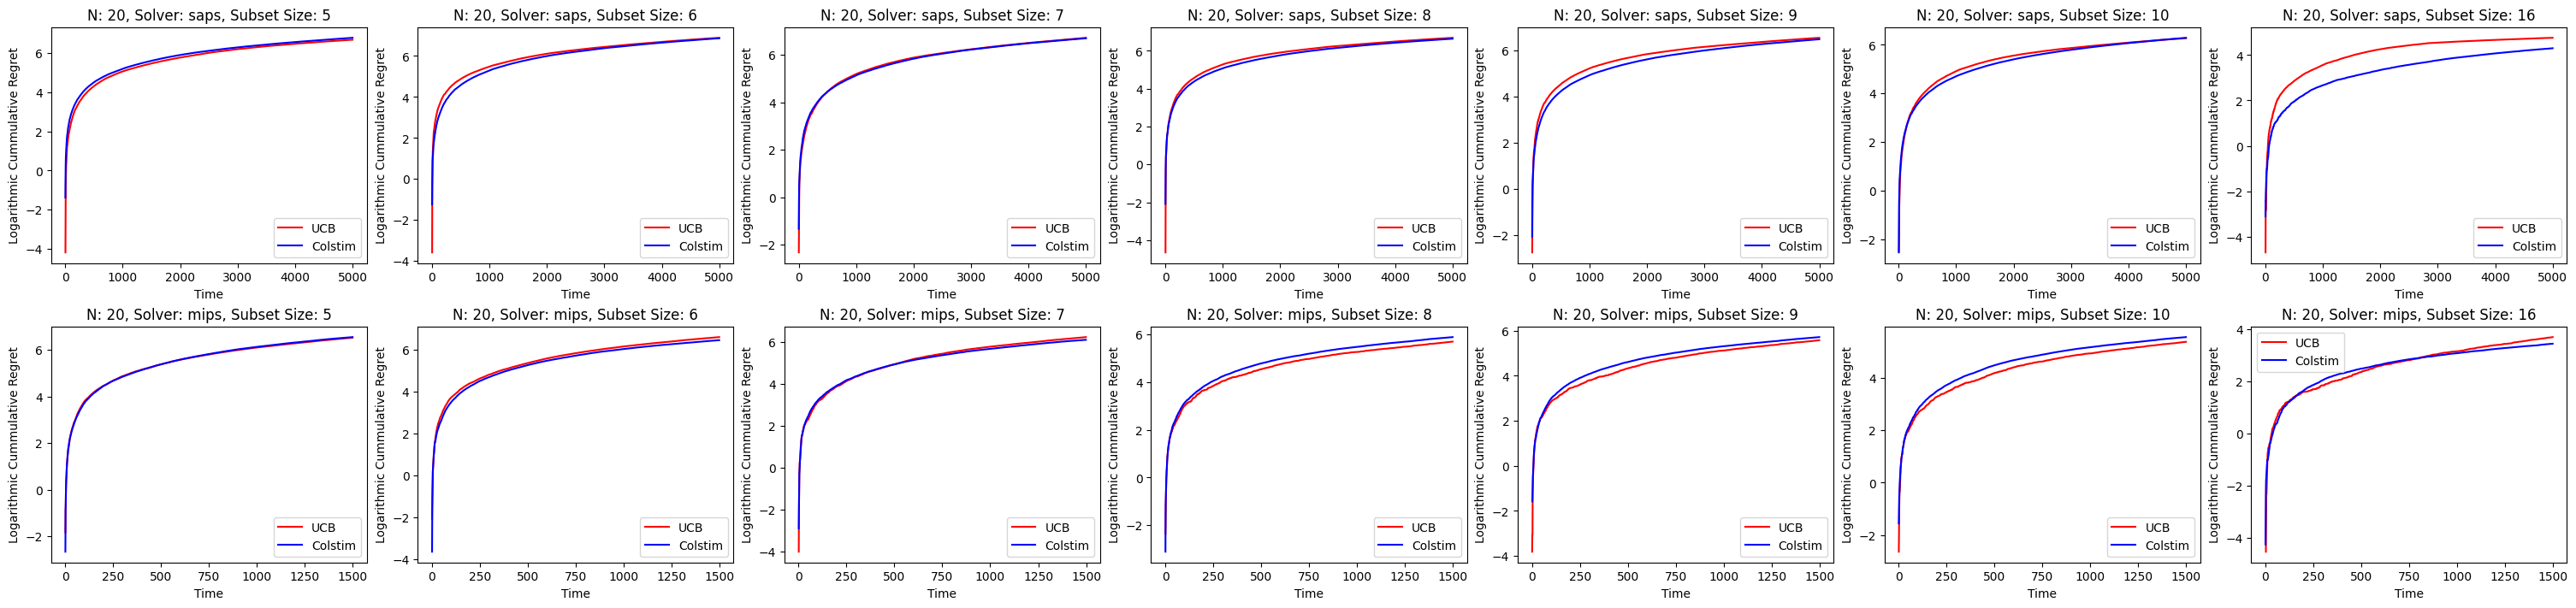

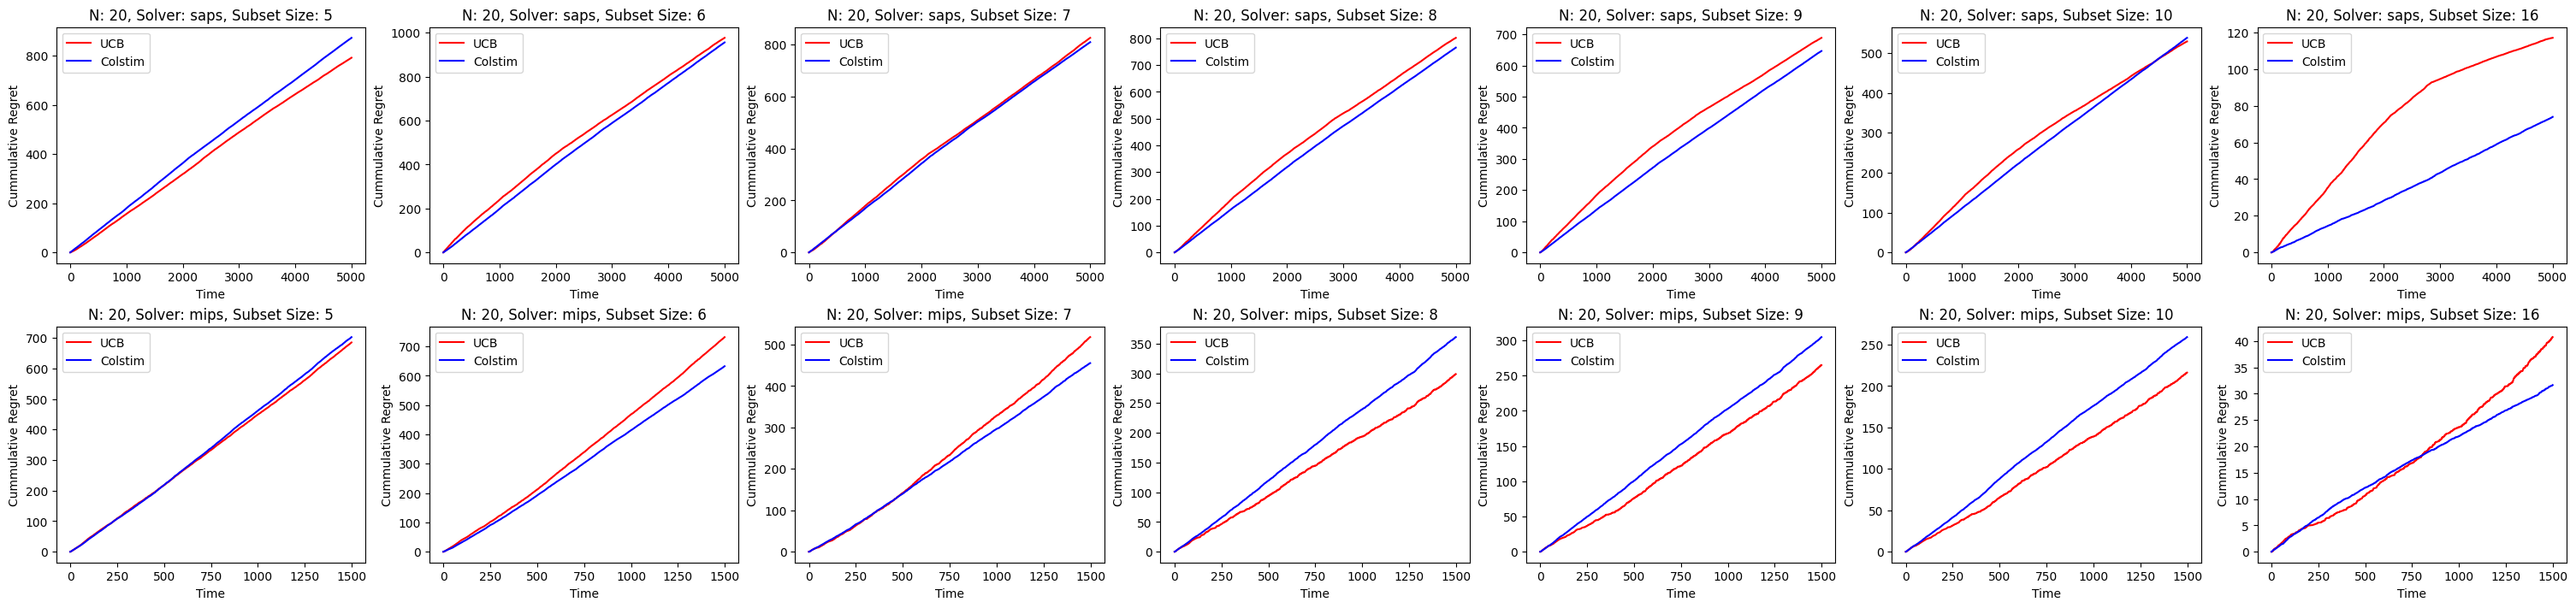

In [6]:
fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
for solver_index, solver in enumerate(solvers):
    for size_index, size in enumerate(subset_size):
        for index, algorithm in enumerate(algorithms):
            regret = np.load(f"Regret_results//regret_{algorithm}_{solver}_{size}.npy")
            cum_reg = compute_cumulative_regret(regret)
            
            ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")
            # ax[solver_index, size_index].fill_between(
            #     range(len(cum_reg[0])), 
            #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     color=colors[index],
            #     alpha=0.2
            # )
            ax[solver_index, size_index].legend()
            ax[solver_index, size_index].set_ylabel("Logarithmic Cummulative Regret")
            ax[solver_index, size_index].set_xlabel("Time")
            ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
plt.show()

fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
for solver_index, solver in enumerate(solvers):
    for size_index, size in enumerate(subset_size):
        for index, algorithm in enumerate(algorithms):
            regret = np.load(f"Regret_results//regret_{algorithm}_{solver}_{size}.npy")
            cum_reg = compute_cumulative_regret(regret)
            
            ax[solver_index, size_index].plot(np.mean(cum_reg, axis=0), color=colors[index], label=f"{algorithm}")
            # ax[solver_index, size_index].fill_between(
            #     range(len(cum_reg[0])), 
            #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     color=colors[index],
            #     alpha=0.2
            # )
            ax[solver_index, size_index].legend()
            ax[solver_index, size_index].set_ylabel("Cummulative Regret")
            ax[solver_index, size_index].set_xlabel("Time")
            ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
plt.show()

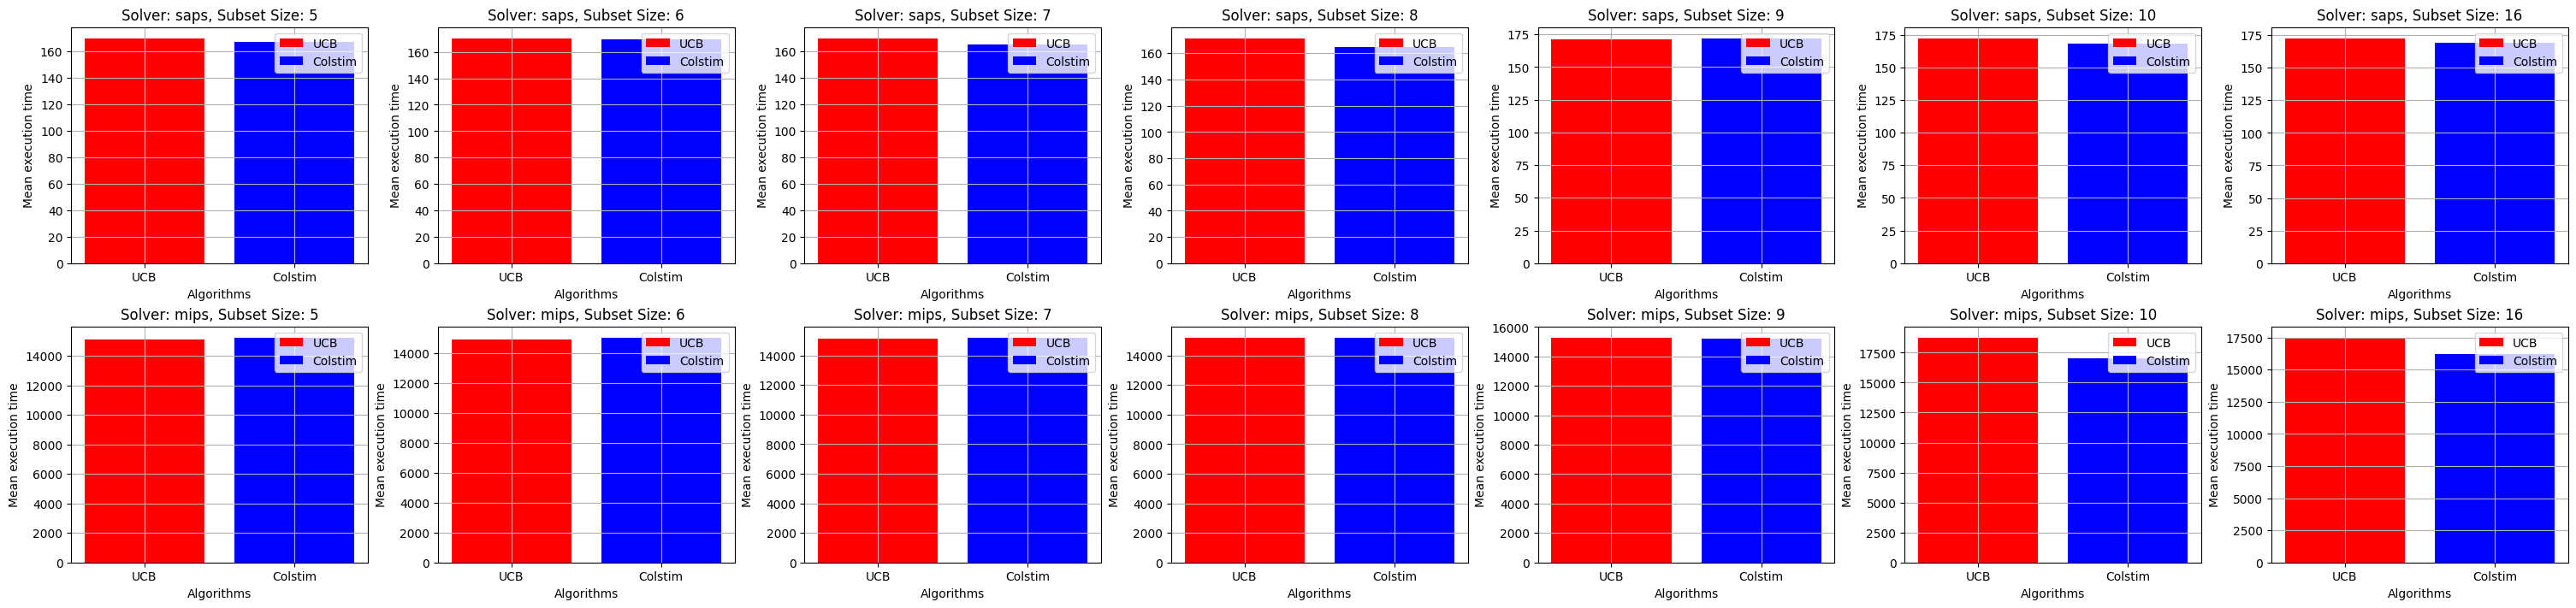

In [4]:
import seaborn as sns

fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
for solver_index, solver in enumerate(solvers):
    for size_index, size in enumerate(subset_size):
        for index, algorithm in enumerate(algorithms):
            execution_time = np.load(f"Execution_times_results//execution_time_{algorithm}_{solver}_{size}.npy")
            
            ax[solver_index, size_index].bar(x=algorithm, height=execution_time.mean(), color=colors[index], label=f"{algorithm}")
            # ax[solver_index, size_index].fill_between(
            #     range(len(cum_reg[0])), 
            #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     color=colors[index],
            #     alpha=0.2
            # )
            ax[solver_index, size_index].legend()
            ax[solver_index, size_index].set_ylabel("Mean execution time")
            ax[solver_index, size_index].set_xlabel("Algorithms")
            ax[solver_index, size_index].set_title(f"Solver: {solver}, Subset Size: {size}")
        ax[solver_index, size_index].grid()
plt.show()

# execution_time = np.load(f"Execution_times_results//execution_time_UCB_saps_5.npy")
# print(execution_time.shape)
# x = ['UCB']
# plt.bar(x=x, height=execution_time.mean())

## Plotting results from Theta0

C:\Users\sshiv\AppData\Local\Temp\ipykernel_20548\453149959.py:22: RuntimeWarning: divide by zero encountered in log
  ax[solver_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


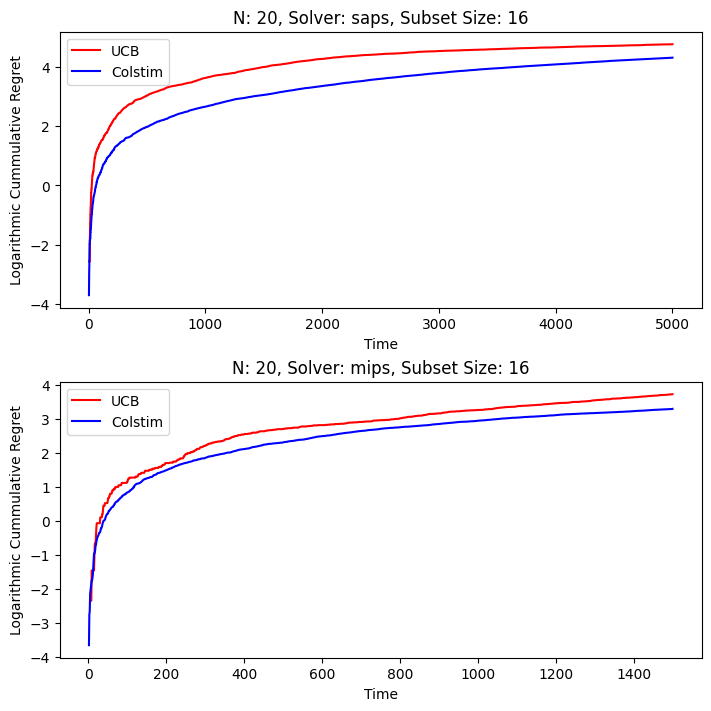

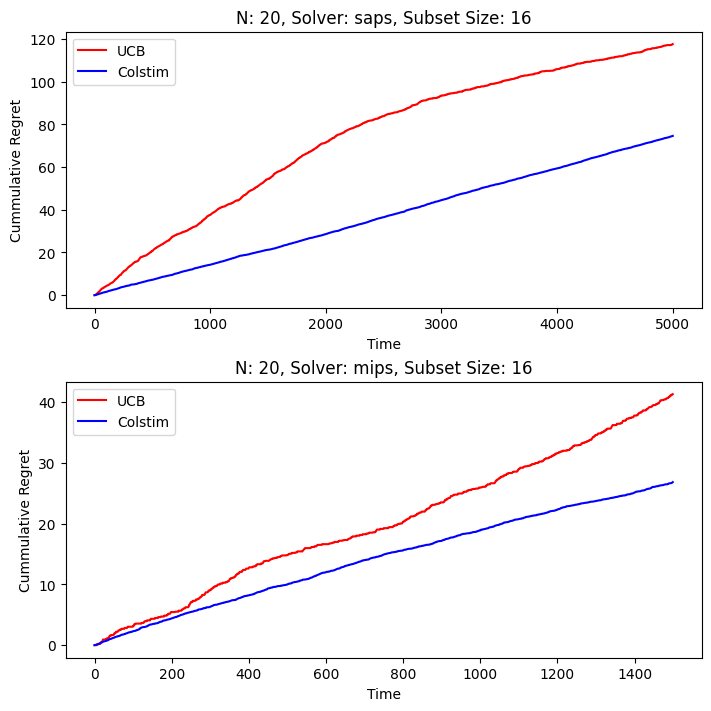

In [3]:
from algorithms import regret_minimizing_algorithms
from util.constants import Solver
from util.metrics import compute_cumulative_regret
import matplotlib.pyplot as plt
import numpy as np

algorithms = [
        algorithm.__name__ for algorithm in regret_minimizing_algorithms
    ]

solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue"]

fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(7, 7), constrained_layout=True)
for solver_index, solver in enumerate(solvers):
    for size_index, size in enumerate(subset_size):
        for index, algorithm in enumerate(algorithms):
            regret = np.load(f"Regret_results_theta0//regret_{algorithm}_{solver}_{size}.npy", allow_pickle=True)
            cum_reg = compute_cumulative_regret(regret)
            
            ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")
            # ax[solver_index, size_index].fill_between(
            #     range(len(cum_reg[0])), 
            #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     color=colors[index],
            #     alpha=0.2
            # )
            ax[solver_index, size_index].legend()
            ax[solver_index, size_index].set_ylabel("Logarithmic Cummulative Regret")
            ax[solver_index, size_index].set_xlabel("Time")
            ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
plt.show()

fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(7, 7), constrained_layout=True)
for solver_index, solver in enumerate(solvers):
    for size_index, size in enumerate(subset_size):
        for index, algorithm in enumerate(algorithms):
            regret = np.load(f"Regret_results_theta0//regret_{algorithm}_{solver}_{size}.npy", allow_pickle=True)
            cum_reg = compute_cumulative_regret(regret)
            
            ax[solver_index, size_index].plot(np.mean(cum_reg, axis=0), color=colors[index], label=f"{algorithm}")
            # ax[solver_index, size_index].fill_between(
            #     range(len(cum_reg[0])), 
            #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     color=colors[index],
            #     alpha=0.2
            # )
            ax[solver_index, size_index].legend()
            ax[solver_index, size_index].set_ylabel("Cummulative Regret")
            ax[solver_index, size_index].set_xlabel("Time")
            ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
plt.show()  

## Plotting Colstim V2 with theta0

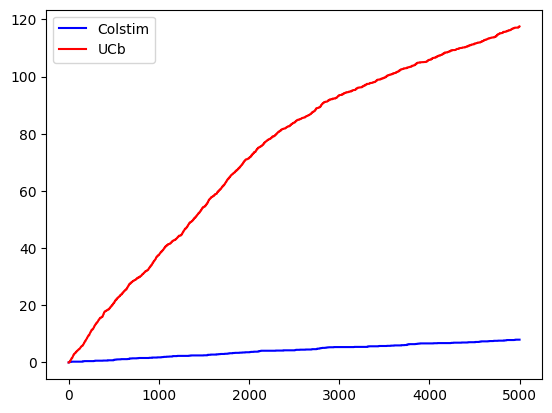

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from util.metrics import compute_cumulative_regret

reg_co = np.load("Regret_results_v2/regret_Colstim_saps_16.npy", allow_pickle=True)
reg_u = np.load("Regret_results_theta0/regret_UCB_saps_16.npy", allow_pickle=True)
cum_reg_co = compute_cumulative_regret(reg_co)
cum_reg_u = compute_cumulative_regret(reg_u)
plt.plot(np.mean(cum_reg_co, axis=0), color="blue", label="Colstim")
plt.plot(np.mean(cum_reg_u, axis=0), color="red", label="UCb")
plt.legend()
plt.show()
